## Overall Prediction Observation


In [11]:
# Define variables
IS_FILTERED = True
ARCHIVED = None

SHOW_HEADER = True
SHOW_LAST_APPEARANCE = None

In [12]:
# Import libraries
import sys
sys.path.append('../prediction/')

import numpy as np
import matplotlib.pyplot as plt

from putils.observation import compute_rmse, compute_mae, compute_mape, load_data

In [13]:
# Load data
datafile = "prediction_result_filtered.csv" if IS_FILTERED else "prediction_result.csv"
dir = "../source/"

dfs = {
    "l1": load_data("l1", datafile=datafile, archived=ARCHIVED, last_appearance=SHOW_LAST_APPEARANCE),
    "l2": load_data("l2", datafile=datafile, archived=ARCHIVED, last_appearance=SHOW_LAST_APPEARANCE),
    "l3": load_data("l3", datafile=datafile, archived=ARCHIVED, last_appearance=SHOW_LAST_APPEARANCE),
}

# Make L1 and L2 data have the same length with L3 if SHOW_LAST_APPEARANCE = None
if SHOW_LAST_APPEARANCE is None:
    dfs["l1"] = dfs["l1"].tail(len(dfs["l3"]))
    dfs["l2"] = dfs["l2"].tail(len(dfs["l3"]))

# Indicate which columns to ignore
IGNORED_COLS = ["Time", "Actual"] # No need to include "FormattedTime" because it is used as index
if IS_FILTERED: IGNORED_COLS.append("Raw")

In [14]:
# Compute RMSE, MAE, and MAPE for each model
for key, df in dfs.items():
    print("Layer", key)
    for column in df.columns:
        if column not in IGNORED_COLS:
            actual = df["Raw"] if IS_FILTERED else df["Actual"]
            rmse = compute_rmse(actual, df[column])
            mape = compute_mape(actual, df[column])
            mae = compute_mae(actual, df[column])
            print(f"{column} - RMSE: {rmse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.2f}%")
    print("------------------")

Layer l1
ARIMA - RMSE: 0.0555, MAE: 0.0440, MAPE: 36.66%
SARIMA - RMSE: 0.0550, MAE: 0.0441, MAPE: 37.30%
RNN - RMSE: 0.0386, MAE: 0.0313, MAPE: 28.18%
LSTM - RMSE: 0.0402, MAE: 0.0329, MAPE: 29.88%
CNN - RMSE: 0.0398, MAE: 0.0329, MAPE: 28.86%
GRU - RMSE: 0.0401, MAE: 0.0326, MAPE: 28.65%
TCN - RMSE: 0.0423, MAE: 0.0346, MAPE: 32.65%
------------------
Layer l2
LINEAR_REGRESSION - RMSE: 0.0387, MAE: 0.0312, MAPE: 27.90%
RANDOM_FOREST - RMSE: 0.0443, MAE: 0.0350, MAPE: 30.70%
FEEDFORWARD_NEURAL_NETWORK - RMSE: 0.0398, MAE: 0.0328, MAPE: 29.26%
------------------
Layer l3
Predicted - RMSE: 0.0398, MAE: 0.0323, MAPE: 28.80%
------------------


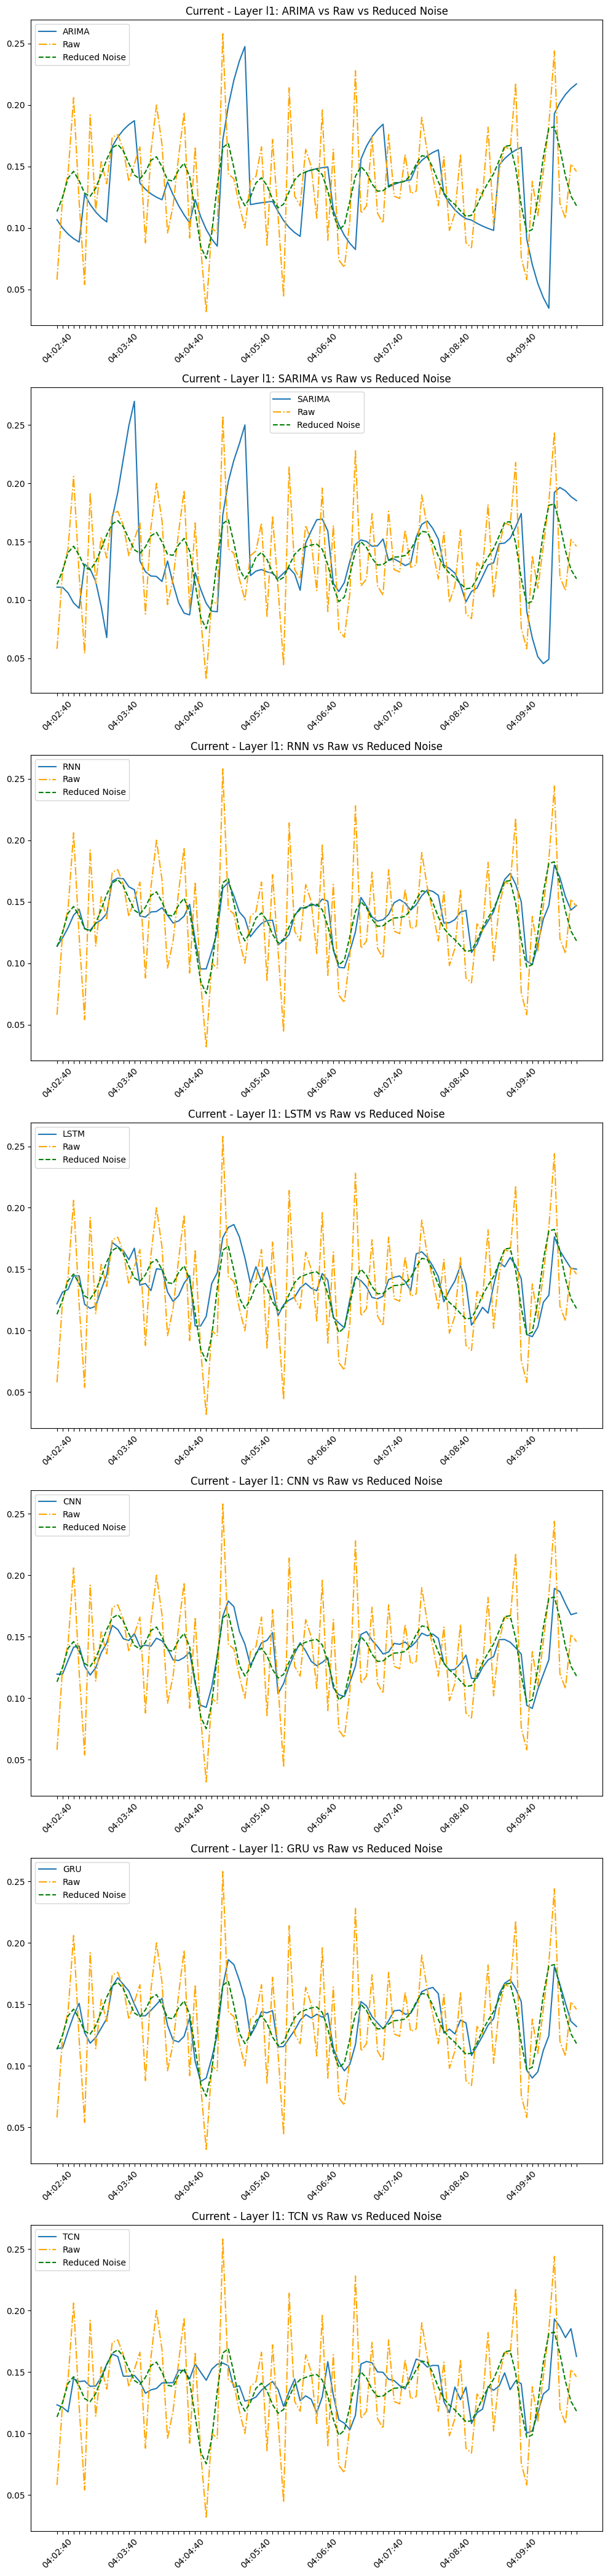

------------------


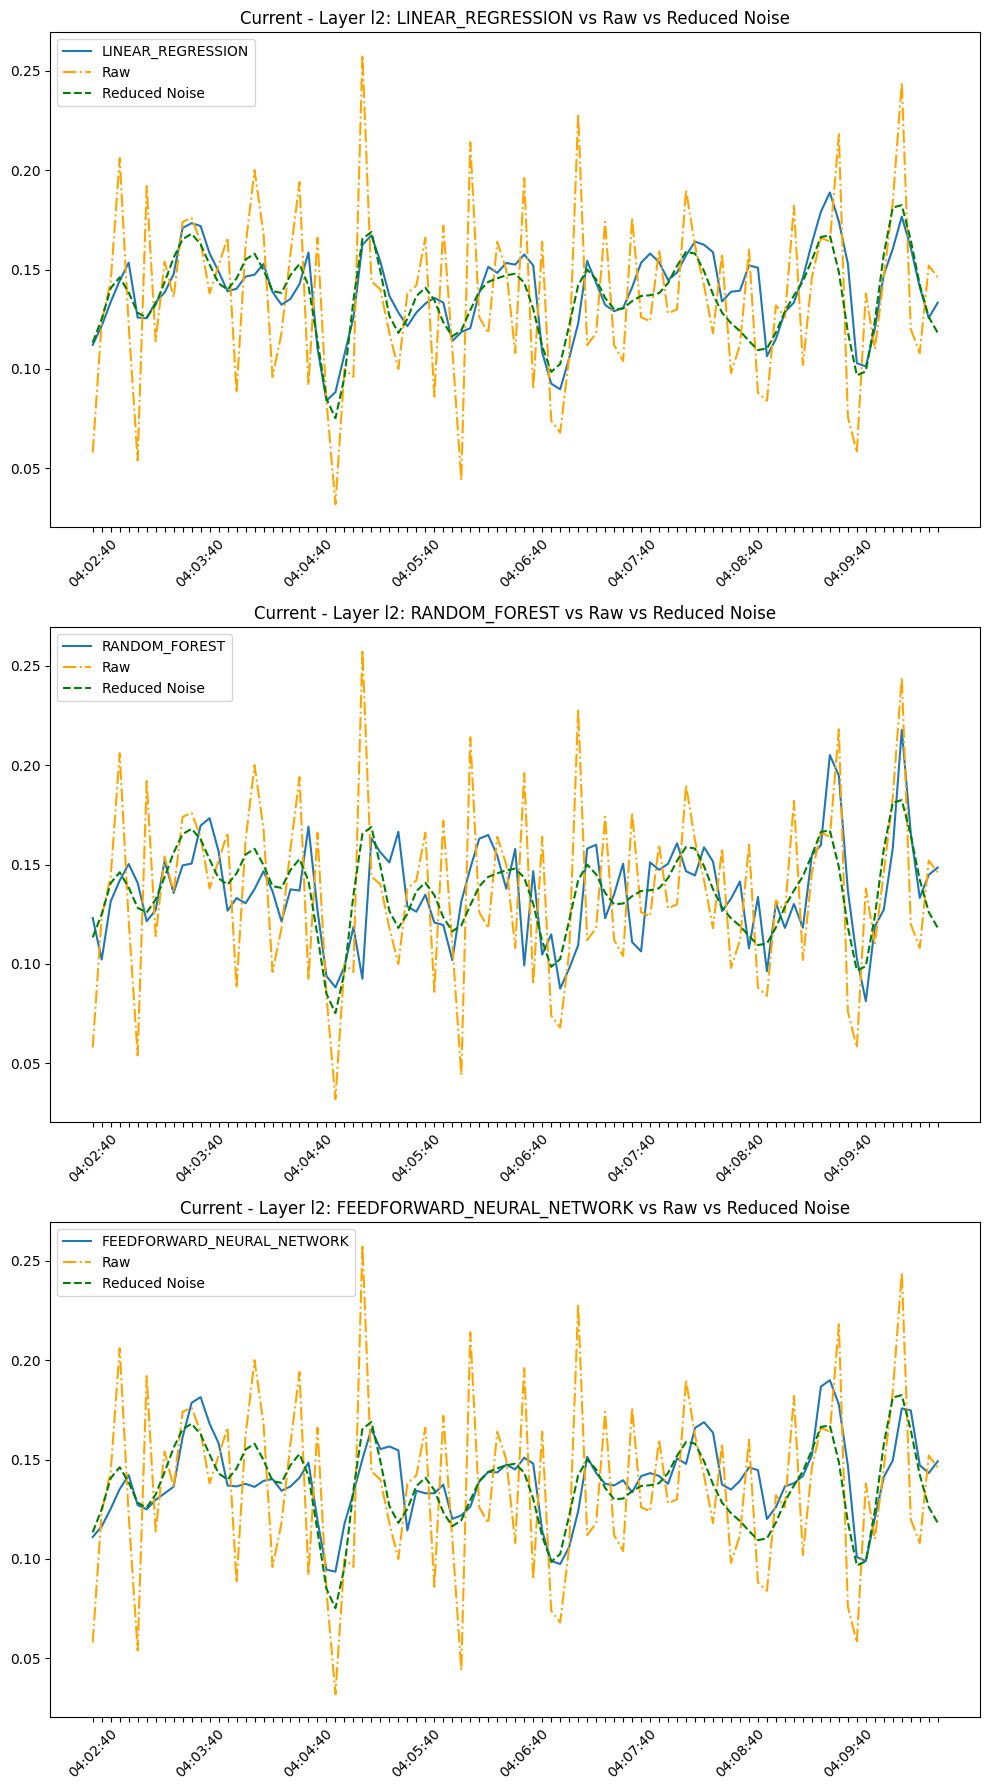

------------------


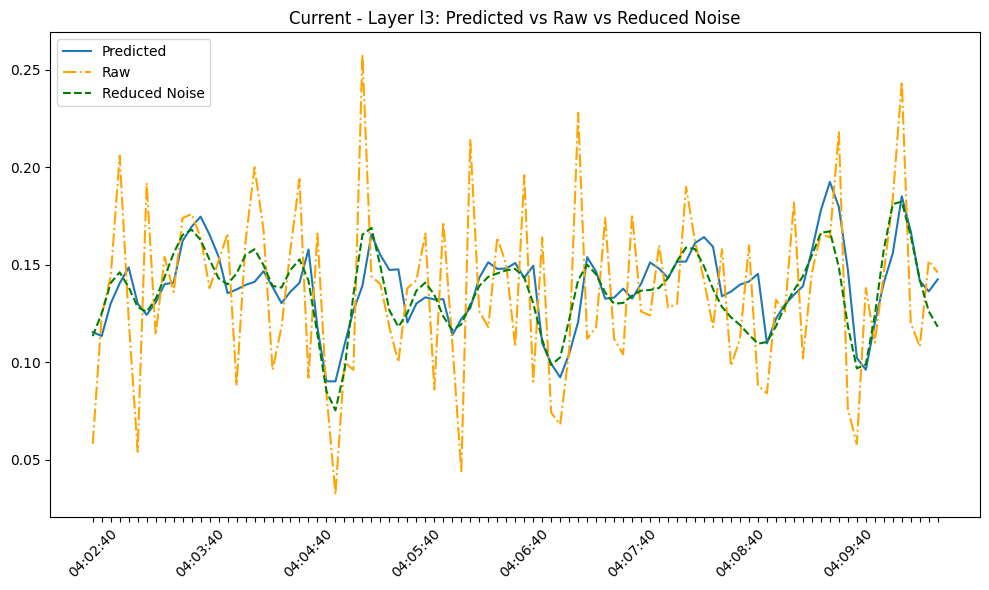

------------------


In [15]:
# Plot the data
header = (str(ARCHIVED) if ARCHIVED is not None else "Current") + " - "
header = header if SHOW_HEADER else ""

for key, df in dfs.items():
    # Plot the data
    fig, axes = plt.subplots(
        nrows=len(df.columns) - len(IGNORED_COLS),
        figsize=(10, 6 * (len(df.columns) - len(IGNORED_COLS))),
    )

    # Ensure axes is always a list or array
    if not isinstance(axes, np.ndarray):
        axes = [axes]

    ax_idx = 0  # Separate index for accessing axes

    for column in df.columns:
        if column not in IGNORED_COLS:
            actual_label = "Reduced Noise" if IS_FILTERED else "Raw"
            actual_color = "green" if IS_FILTERED else "orange"
            axes[ax_idx].plot(df.index, df[column], label=column)
            if IS_FILTERED:
                axes[ax_idx].plot(
                    df.index,
                    df["Raw"],
                    label="Raw",
                    linestyle="-.",
                    color="orange",
                )  # Added this line to plot the Raw values
            axes[ax_idx].plot(
                df.index,
                df["Actual"],
                label=actual_label,
                linestyle="--",
                color=actual_color,
            )

            # Sparse Tick Labels logic
            n = 12  # Display every n-th label
            for index, label in enumerate(axes[ax_idx].xaxis.get_ticklabels()):
                if index % n != 0:
                    label.set_visible(False)

            # Rotate the visible x-axis labels
            axes[ax_idx].tick_params(axis="x", rotation=45)

            axes[ax_idx].legend()
            # axes[ax_idx].grid(True) # Uncomment this line to show grid lines
            title = f"{header}Layer {key}: {column} vs Raw"
            if IS_FILTERED:
                title += " vs Reduced Noise"
            axes[ax_idx].set_title(title)
            ax_idx += 1  # Increment ax_idx

    plt.tight_layout()
    plt.show()
    print("------------------")